# W+c Analysis (charm tagging)

This analysis will focus on the selection of W+c Events for c-tagging study. The dataset used for this is: [W1JetsToLNu_TuneCP5_13TeV-madgraphMLM-pythia8](https://opendata.cern.ch/record/69544).

In [1]:
import ROOT as rt
import uproot as uprt
import mplhep as mh
import matplotlib.pyplot as plt
import awkward as ak
import numpy as np
import vector as v

In [2]:
# Defining the style for plots (CMS Style)
plt.style.use(mh.style.CMS)
plt.rcParams.update({
    "font.size": 17,
    "axes.labelsize": 17,
    "axes.titlesize": 17,
    "xtick.labelsize": 17,
    "ytick.labelsize": 17,
    "legend.fontsize": 17
})

# Defining the function for making histograms
def make_hist(data, bins, range, xlabel, ylabel, label, fname=None, logy=False):
    histo, edges = np.histogram(data, bins=bins, range=range)
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    mh.histplot(histo, edges, histtype="step", label=label, ax=ax)
    mh.cms.label("Open Data", data=True, lumi=None, com=13, year=2016, loc=0)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()
    if logy:
        ax.set_yscale("log")
    if fname:
        plt.savefig(fname)
    plt.show()

In [3]:
# Loading the ROOT file
btvNanoAODFile = uprt.open("../datasets/nano106X_on_mini106X_2017_mc_NANOAOD_W1Jets_to_LNu_250K.root")
Events = btvNanoAODFile["Events"]

In [4]:
# # RecoJets collections
RecoJet_keys = Events.keys(filter_name="Jet_*")
for RecoJets in Events.iterate(RecoJet_keys, step_size=Events.num_entries, library="ak"):
    break

# Muon Collections

RecoMuon_keys = Events.keys(filter_name="Muon_*")
for RecoMuons in Events.iterate(RecoMuon_keys, step_size=Events.num_entries, library="ak"):
    break

# Electron Collections
RecoElectron_keys = Events.keys(filter_name="Electron_*")
for RecoElectrons in Events.iterate(RecoElectron_keys, step_size=Events.num_entries, library="ak"):
    break

# GenJets collections
GenJet_keys = Events.keys(filter_name="GenJet_*")
for GenJets in Events.iterate(GenJet_keys, step_size=Events.num_entries, library="ak"):
    break

# MET collection
MET_keys = Events.keys(filter_name="MET_*")
for METs in Events.iterate(MET_keys, step_size=Events.num_entries, library="ak"):
    break

## W $\rightarrow$ $\mu + \nu$ Event Selection:

This part of the notebook selects all the events that pass the following cuts:
- Jet $p_{T}$ > 30 GeV
- Muon $p_{T}$ > 20 GeV
- Muon $\eta$ > 2.4
- Muon_pfRelIso04_all > 0.15
- $M_{T}$ > 55 GeV
- Events with two opposite signed muons with $p_{T}$ > 20 GeV

In [5]:
print(Events.keys(filter_name="Muon_*"))

['Muon_dxy', 'Muon_dxyErr', 'Muon_dxybs', 'Muon_dz', 'Muon_dzErr', 'Muon_eta', 'Muon_ip3d', 'Muon_jetPtRelv2', 'Muon_jetRelIso', 'Muon_mass', 'Muon_miniPFRelIso_all', 'Muon_miniPFRelIso_chg', 'Muon_pfRelIso03_all', 'Muon_pfRelIso03_chg', 'Muon_pfRelIso04_all', 'Muon_phi', 'Muon_pt', 'Muon_ptErr', 'Muon_segmentComp', 'Muon_sip3d', 'Muon_softMva', 'Muon_tkRelIso', 'Muon_tunepRelPt', 'Muon_mvaLowPt', 'Muon_mvaTTH', 'Muon_charge', 'Muon_jetIdx', 'Muon_nStations', 'Muon_nTrackerLayers', 'Muon_pdgId', 'Muon_tightCharge', 'Muon_fsrPhotonIdx', 'Muon_highPtId', 'Muon_highPurity', 'Muon_inTimeMuon', 'Muon_isGlobal', 'Muon_isPFcand', 'Muon_isStandalone', 'Muon_isTracker', 'Muon_jetNDauCharged', 'Muon_looseId', 'Muon_mediumId', 'Muon_mediumPromptId', 'Muon_miniIsoId', 'Muon_multiIsoId', 'Muon_mvaId', 'Muon_mvaLowPtId', 'Muon_pfIsoId', 'Muon_puppiIsoId', 'Muon_softId', 'Muon_softMvaId', 'Muon_tightId', 'Muon_tkIsoId', 'Muon_triggerIdLoose', 'Muon_genPartIdx', 'Muon_genPartFlav', 'Muon_cleanmask']


### Event Selection

In [6]:
# Muon Selection Cuts
Muon_PassCuts = (
    (RecoMuons["Muon_pt"] > 35) & 
    (abs(RecoMuons["Muon_eta"]) < 2.4) &
    (abs(RecoMuons["Muon_pfRelIso04_all"]) < 0.15) 
    # (RecoMuons["Muon_tightId"] == 1) # This cut makes no sub-leading muon pass 
)   
# Missing Trasnverse Mass Cut - Muon
Muon_Mt = np.sqrt(2 * RecoMuons["Muon_pt"] * METs["MET_pt"] * (1 - np.cos(RecoMuons["Muon_phi"] - METs["MET_phi"])))

# Apply the MT cut (If any other cuts are to be added, they can be added here)
Muon_PassCuts = (
    Muon_PassCuts & 
    (Muon_Mt > 60)
)
# Selecting Muons that pass the cuts
Selected_Muons = RecoMuons[Muon_PassCuts]

# Leading Muons and Sub-Leading Muons  
Sort_Selected_Muons = Selected_Muons[ak.argsort(Selected_Muons["Muon_pt"], ascending=False)]
# Leading Muon pt
Leading_Muon_pt = ak.firsts(Sort_Selected_Muons["Muon_pt"])
# Sub-Leading Muon pt
Sub_Leading_Muons_Pad = ak.pad_none(Sort_Selected_Muons, 2, axis=1) 
Sub_Leading_Muon_pt = ak.fill_none(Sub_Leading_Muons_Pad[:, 1].Muon_pt, -1) # Accesses the second element of the padded array and fills None with -1

# Number of selected muons in the event
nSelected_Muons = ak.num(Sort_Selected_Muons["Muon_pt"])

# PassCuts for OS muons
OS_mask = (
    (ak.sum(Sort_Selected_Muons["Muon_charge"], axis=1)==0) | 
    (nSelected_Muons >= 2) |
    (Sub_Leading_Muon_pt > 20)
)
Selected_Muons_PassCuts = ~OS_mask 

# Final Selected Muons after all cuts
W_Muons = Sort_Selected_Muons[Selected_Muons_PassCuts]

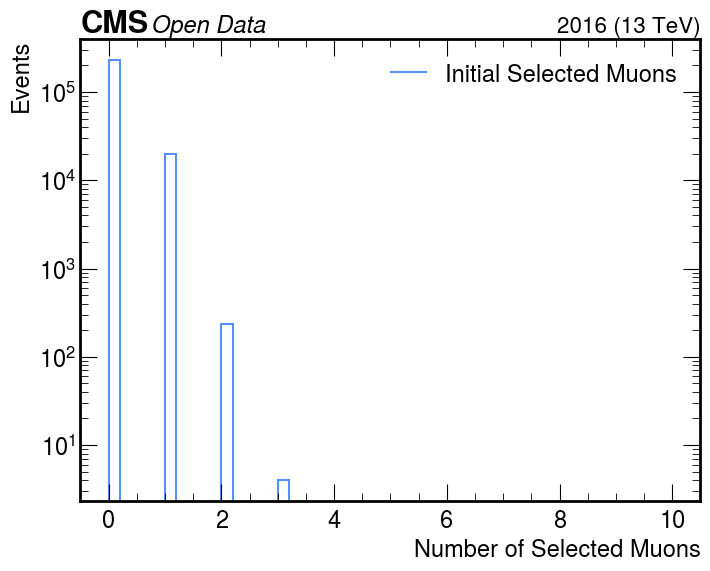

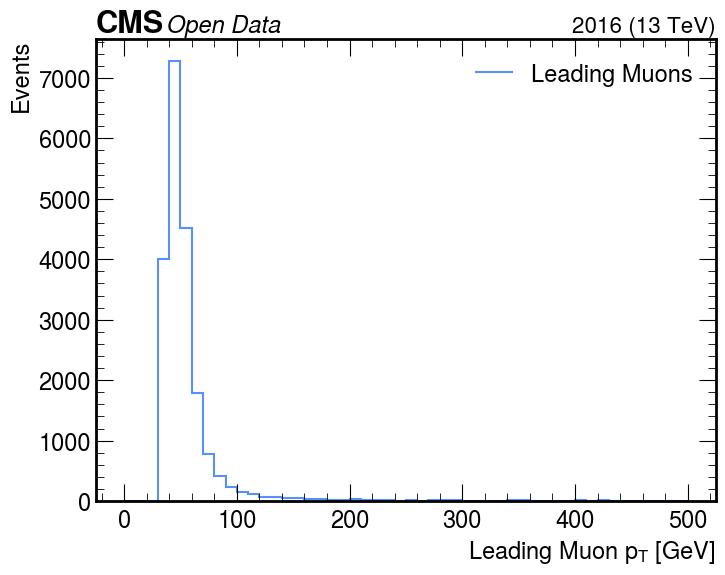

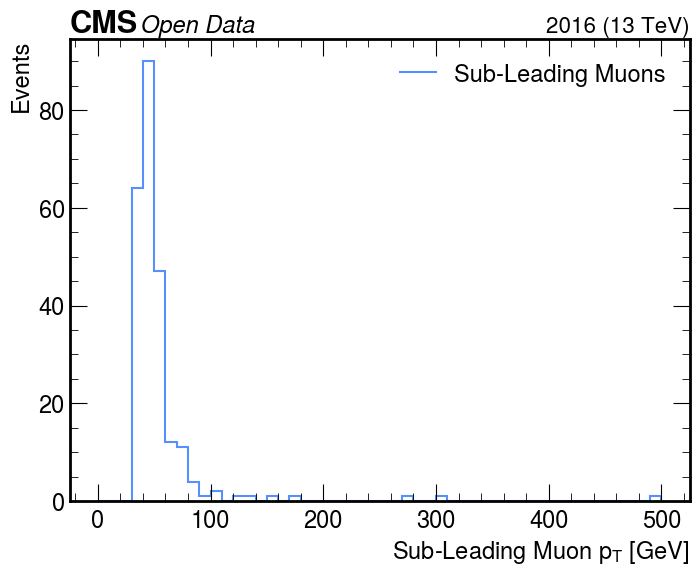

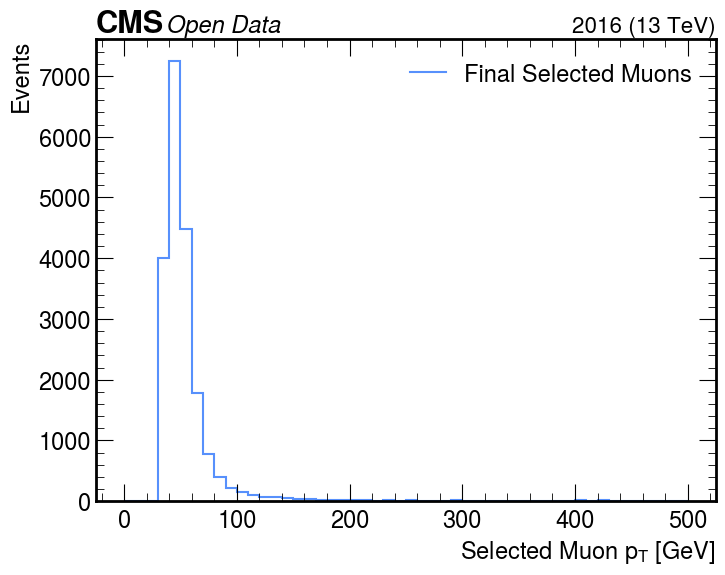

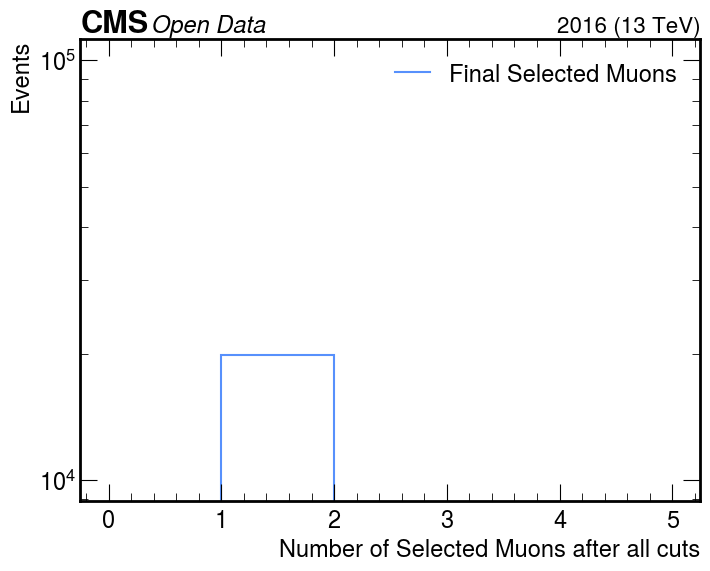

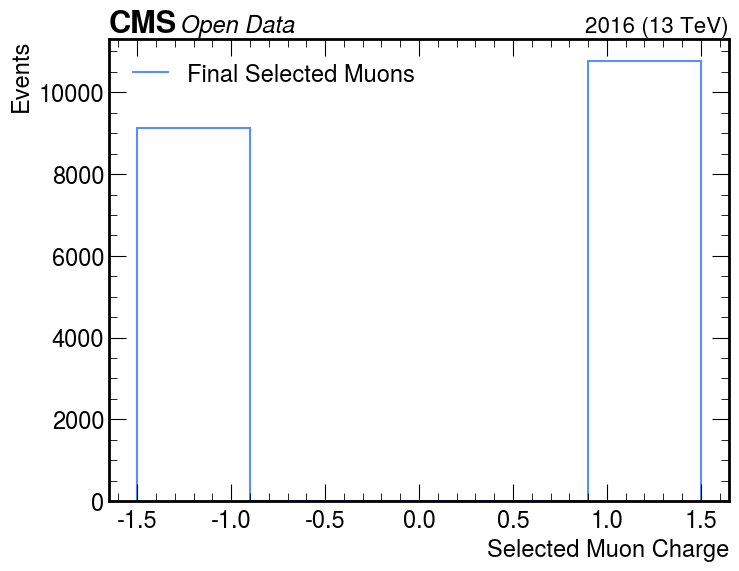

In [7]:
#Plotting the Number of Selected Muons
make_hist(
    nSelected_Muons,
    bins=50,
    range=(0, 10),
    xlabel="Number of Selected Muons",
    ylabel="Events",
    label="Initial Selected Muons",
    fname="Plots/nSelected_Muons.png",
    logy=True
)

# Plotting the Leading Muon pt
make_hist(
    Leading_Muon_pt,
    bins=50,
    range=(0, 500),
    xlabel="Leading Muon $p_{T}$ [GeV]",
    ylabel="Events",
    label="Leading Muons",
    fname="Plots/Leading_Muon_pt.png",
    logy=False
)

# Plotting the Sub-Leading Muon pt
make_hist(
    Sub_Leading_Muon_pt,
    bins=50,
    range=(0, 500),
    xlabel="Sub-Leading Muon $p_{T}$ [GeV]",
    ylabel="Events",
    label="Sub-Leading Muons",
    fname="Plots/Sub_Leading_Muon_pt.png",
    logy=False
)

# Plotting the PT of Selected Muons and nSelected Muons after all cuts
Selected_Muons_pt = ak.to_numpy(ak.flatten(W_Muons["Muon_pt"]))
nSelected_Muons_final = ak.num(W_Muons["Muon_pt"])

make_hist(
    Selected_Muons_pt,
    bins=50,
    range=(0, 500),
    xlabel="Selected Muon $p_{T}$ [GeV]",
    ylabel="Events",
    label="Final Selected Muons",
    fname="Plots/Selected_Muons_pt.png",
    logy=False
)

make_hist(
    nSelected_Muons_final,
    bins=5,
    range=(0, 5),
    xlabel="Number of Selected Muons after all cuts",
    ylabel="Events",
    label="Final Selected Muons",
    fname="Plots/nSelected_Muons_final.png",
    logy=True
)

# Selected Muons Charge
Selected_Muons_Charge = ak.to_numpy(ak.flatten(W_Muons["Muon_charge"]))

make_hist(
    Selected_Muons_Charge,
    bins=5,
    range=(-1.5, 1.5),
    xlabel="Selected Muon Charge",
    ylabel="Events",
    label="Final Selected Muons",
    fname="Plots/Selected_Muons_Charge.png",
    logy=False
)

## W $\rightarrow$ $e + \nu$ Event Selection:

This part of the notebook selects all the events that pass the following cuts:
- Jet $p_{T}$ > 30 GeV
- Electron $p_{T}$ > 20 GeV
- Electron $\eta$ > 2.4
- Electron_pfRelIso04_all > 0.15
- $M_{T}$ > 55 GeV
- Events with two opposite signed electrons with $p_{T}$ > 20 GeV

In [8]:
print(Events.keys(filter_name="Electron_*"))

['Electron_deltaEtaSC', 'Electron_dr03EcalRecHitSumEt', 'Electron_dr03HcalDepth1TowerSumEt', 'Electron_dr03TkSumPt', 'Electron_dr03TkSumPtHEEP', 'Electron_dxy', 'Electron_dxyErr', 'Electron_dz', 'Electron_dzErr', 'Electron_eInvMinusPInv', 'Electron_energyErr', 'Electron_eta', 'Electron_hoe', 'Electron_ip3d', 'Electron_jetPtRelv2', 'Electron_jetRelIso', 'Electron_mass', 'Electron_miniPFRelIso_all', 'Electron_miniPFRelIso_chg', 'Electron_mvaFall17V2Iso', 'Electron_mvaFall17V2noIso', 'Electron_pfRelIso03_all', 'Electron_pfRelIso03_chg', 'Electron_phi', 'Electron_pt', 'Electron_r9', 'Electron_scEtOverPt', 'Electron_sieie', 'Electron_sip3d', 'Electron_mvaTTH', 'Electron_charge', 'Electron_cutBased', 'Electron_jetIdx', 'Electron_pdgId', 'Electron_photonIdx', 'Electron_tightCharge', 'Electron_vidNestedWPBitmap', 'Electron_vidNestedWPBitmapHEEP', 'Electron_convVeto', 'Electron_cutBased_HEEP', 'Electron_isPFcand', 'Electron_jetNDauCharged', 'Electron_lostHits', 'Electron_mvaFall17V2Iso_WP80', '

### Event Selection

In [9]:
# Electron Selection Cuts
Electron_PassCuts = (
    (RecoElectrons["Electron_pt"] > 35) &
    (abs(RecoElectrons["Electron_eta"]) < 2.4) &
    (abs(RecoElectrons["Electron_pfRelIso03_all"]) < 0.15) 
    # (RecoElectrons["Electron_tightId"] == 1) # This cut makes no sub-leading electron pass 
)   
# Missing Transverse Mass Cut - Electron
Electron_Mt = np.sqrt(2 * RecoElectrons["Electron_pt"] * METs["MET_pt"] * (1 - np.cos(RecoElectrons["Electron_phi"] - METs["MET_phi"])))

# Apply the MT cut (If any other cuts are to be added, they can be added here)
Electron_PassCuts = (
    Electron_PassCuts & 
    (Electron_Mt > 55)
)
# Selecting Electrons that pass the cuts
Selected_Electrons = RecoElectrons[Electron_PassCuts]

# Leading Electrons and Sub-Leading Electrons  
Sort_Selected_Electrons = Selected_Electrons[ak.argsort(Selected_Electrons["Electron_pt"], ascending=False)]
# Leading Electron pt
Leading_Electron_pt = ak.firsts(Sort_Selected_Electrons["Electron_pt"])
# Sub-Leading Electron pt
Sub_Leading_Electrons_Pad = ak.pad_none(Sort_Selected_Electrons, 2, axis=1) 
Sub_Leading_Electron_pt = ak.fill_none(Sub_Leading_Electrons_Pad[:, 1].Electron_pt, -1) # Accesses the second element of the padded array and fills None with -1

# Number of selected electrons in the event
nSelected_Electrons = ak.num(Sort_Selected_Electrons["Electron_pt"])

# PassCuts for OS electrons
OS_mask = (
    (ak.sum(Sort_Selected_Electrons["Electron_charge"], axis=1)==0) |
    (nSelected_Electrons >= 2) | (Sub_Leading_Electron_pt > 20)
) 
Selected_Electrons_PassCuts = ~OS_mask 

# Final Selected Electrons after all cuts
final_Selected_Electrons = Sort_Selected_Electrons[Selected_Electrons_PassCuts]

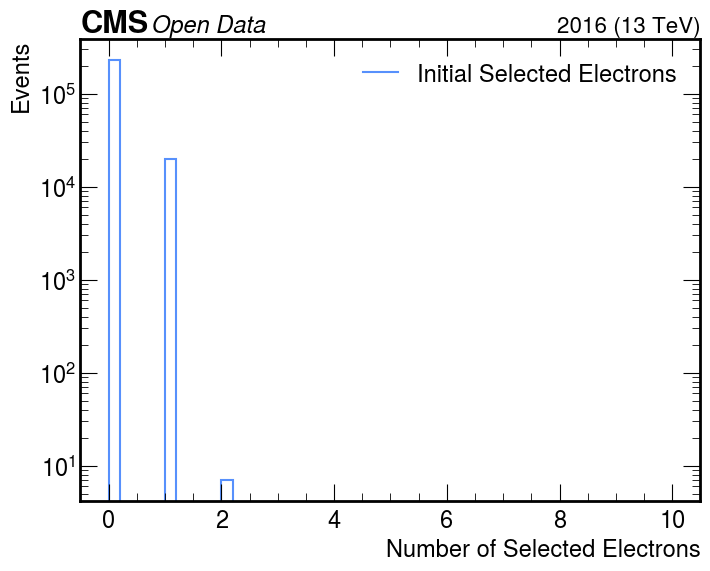

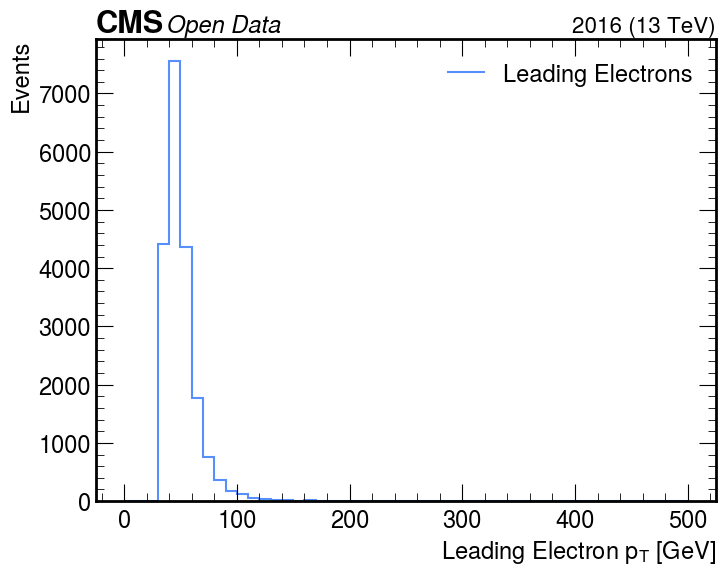

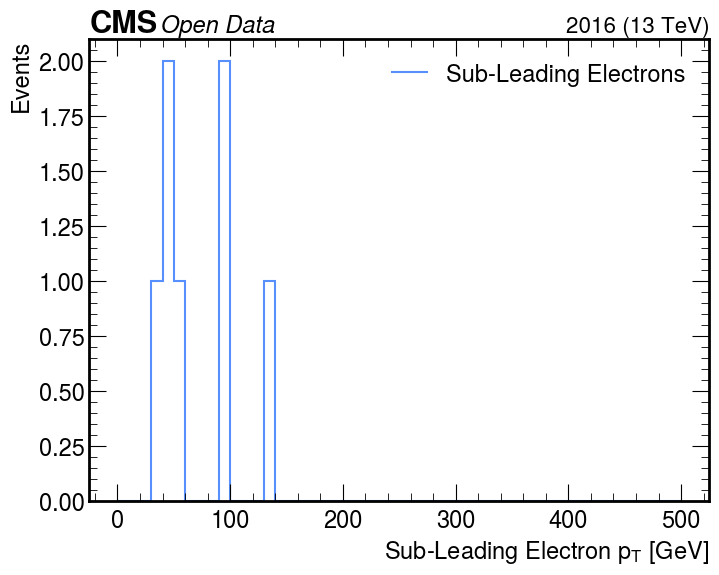

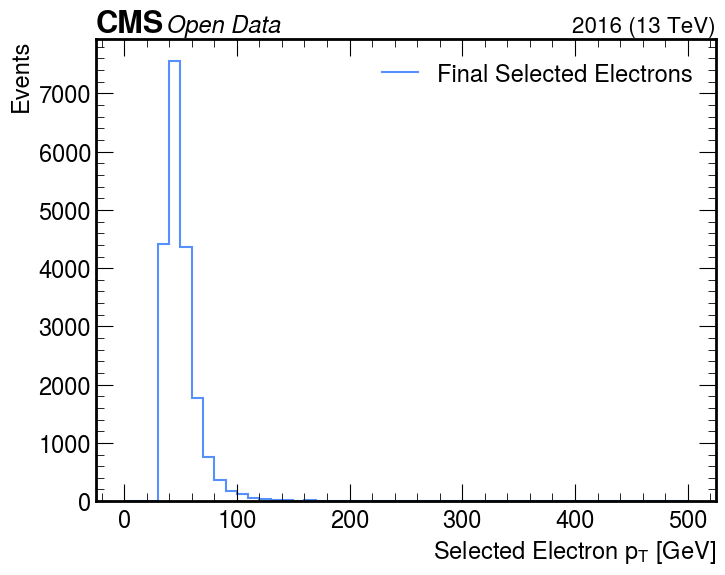

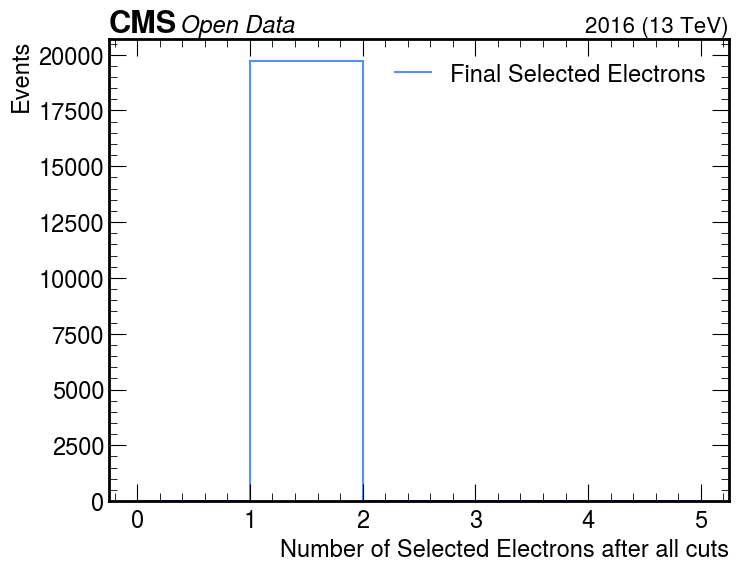

In [10]:
# Plotting the Number of Selected Electrons
make_hist(
    nSelected_Electrons,
    bins=50,
    range=(0, 10),
    xlabel="Number of Selected Electrons",
    ylabel="Events",
    label="Initial Selected Electrons",
    fname="Plots/nSelected_Electrons.png",
    logy=True
)

# Plotting the Leading Electron pt
make_hist(
    Leading_Electron_pt,
    bins=50,
    range=(0, 500),
    xlabel="Leading Electron $p_{T}$ [GeV]",
    ylabel="Events",
    label="Leading Electrons",
    fname="Plots/Leading_Electron_pt.png",
    logy=False
)

# Plotting the Sub-Leading Electron pt
make_hist(
    Sub_Leading_Electron_pt,
    bins=50,
    range=(0, 500),
    xlabel="Sub-Leading Electron $p_{T}$ [GeV]",
    ylabel="Events",
    label="Sub-Leading Electrons",
    fname="Plots/Sub_Leading_Electron_pt.png",
    logy=False
)

# Plotting the PT of Selected Electrons and nSelected Electrons after all cuts
Selected_Electrons_pt = ak.to_numpy(ak.flatten(final_Selected_Electrons["Electron_pt"]))
nSelected_Electrons_final = ak.num(final_Selected_Electrons["Electron_pt"])

make_hist(
    Selected_Electrons_pt,
    bins=50,
    range=(0, 500),
    xlabel="Selected Electron $p_{T}$ [GeV]",
    ylabel="Events",
    label="Final Selected Electrons",
    fname="Plots/Selected_Electrons_pt.png",
    logy=False
)

make_hist(
    nSelected_Electrons_final,
    bins=5,
    range=(0, 5),
    xlabel="Number of Selected Electrons after all cuts",
    ylabel="Events",
    label="Final Selected Electrons",
    fname="Plots/nSelected_Electrons_final.png",
    logy=False
)

## SL channel: W+c 

In [11]:
# Jet cuts and finding which jets are from Charm quarks:
Jet_PassCuts = (
    (RecoJets["Jet_pt"] > 30) &
    (abs(RecoJets["Jet_eta"]) < 2.4)
)
# Muon Selection for W + c analysis:
Mu_PassCuts = (
    (abs(RecoMuons["Muon_eta"]) < 2.4) &
    (RecoMuons["Muon_pt"] < 25) &
    (abs(RecoMuons["Muon_pfRelIso04_all"]) > 0.2) &
    (RecoMuons["Muon_jetIdx"] >= 0) &
    (RecoMuons["Muon_tightId"] == 1)
)
# Muon Selection Cuts:
Jet_Muons = RecoMuons[Mu_PassCuts]
Sort_Jet_Muons = Jet_Muons[ak.argsort(Jet_Muons["Muon_pt"], ascending=False)]

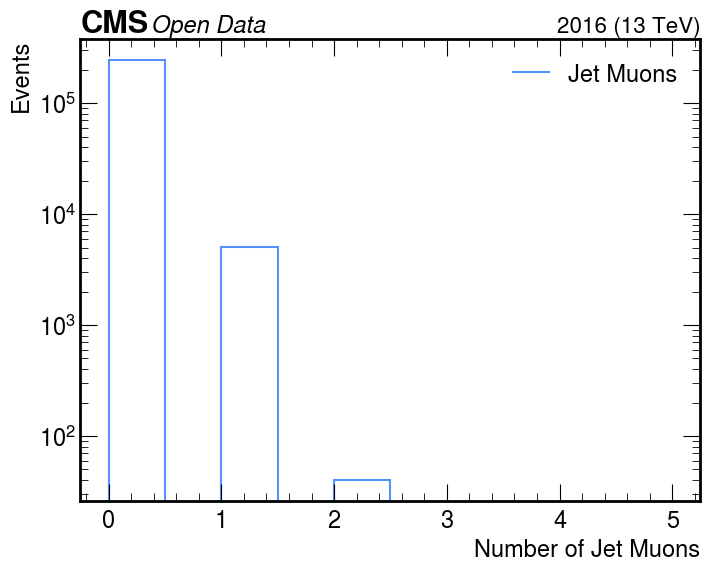

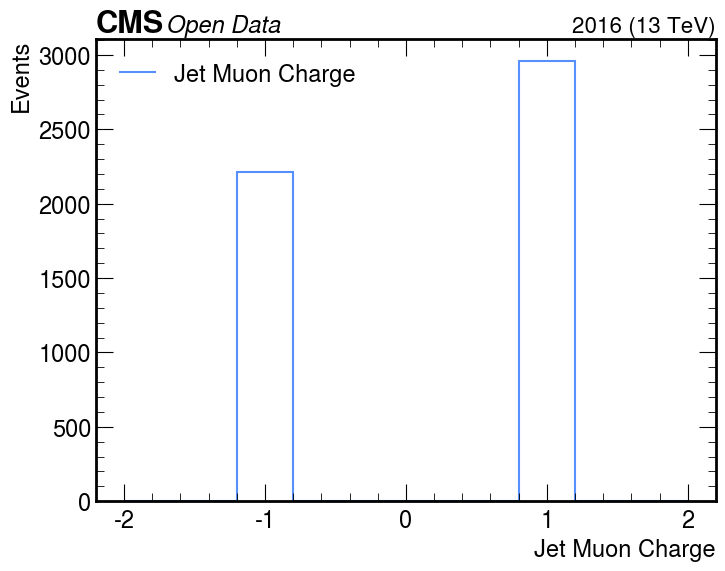

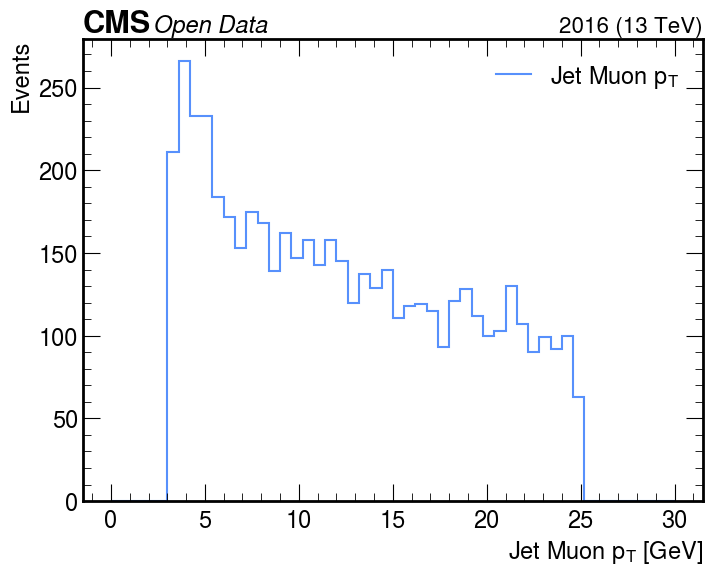

In [12]:
# Number of Jet Muons:
nJet_Muons = ak.num(Sort_Jet_Muons["Muon_pt"])
make_hist(
    nJet_Muons,
    bins=10,
    range=(0, 5),
    xlabel="Number of Jet Muons",
    ylabel="Events",
    label="Jet Muons",
    fname="Plots/nJet_Muons.png",
    logy=True
)

# Jet Muon Charge
Jet_Muon_Charge = ak.to_numpy(ak.flatten(Sort_Jet_Muons["Muon_charge"]))
make_hist(
    Jet_Muon_Charge,
    bins=10,
    range=(-2, 2),
    xlabel="Jet Muon Charge",
    ylabel="Events",
    label="Jet Muon Charge",
    fname="Plots/Jet_Muon_Charge.png",
    logy=False
)

#Jet Muon Pt:
Jet_Muon_Pt = ak.to_numpy(ak.flatten(Sort_Jet_Muons["Muon_pt"]))
make_hist(
    Jet_Muon_Pt,
    bins=50,
    range=(0, 30),
    xlabel="Jet Muon $p_{T}$ [GeV]",
    ylabel="Events",
    label="Jet Muon $p_{T}$",
    fname="Plots/Jet_Muon_Pt.png",
    logy=False
)

In [13]:
# OS - SS:
W_muon_charge = ak.firsts(W_Muons["Muon_charge"])
Jet_muon_charge = ak.firsts(Sort_Jet_Muons["Muon_charge"])

# OS - SS Events:
is_OS = (W_muon_charge + Jet_muon_charge) == 0
is_SS = (W_muon_charge + Jet_muon_charge) != 0

ValueError: cannot broadcast RegularArray of size 19900 with RegularArray of size 250000 in add